In [1]:
using Gen
using PyPlot

In [2]:
bearing(x, y) = atan(y, x)

@gen function model(T::Int)
    
    measurement_noise = 0.005
    velocity_var = (1.0/1e6)

    xs = Vector{Float64}(undef, T+1)
    ys = Vector{Float64}(undef, T+1)

    # prior on initial x-coordinate
    x = @trace(normal(0.01, 0.01), :x0)
       
    # prior on initial y-coordinate
    y = @trace(normal(0.95, 0.01), :y0)
    
    # prior on x-component of initial velocity
    vx = @trace(normal(0.002, 0.01), :vx0)
    
    # prior on y-component of initial velocity
    vy = @trace(normal(-0.013, 0.01), :vy0)
    
    # initial bearing measurement
    @trace(normal(bearing(x, y), measurement_noise), :z0)

    # record position
    xs[1] = x
    ys[1] = y
    
    # generate successive states and measurements
    for t=1:T
        
        # update the state of the point
        vx = @trace(normal(vx, sqrt(velocity_var)), (:vx, t))
        vy = @trace(normal(vy, sqrt(velocity_var)), (:vy, t))
        x += vx
        y += vy
        
        # bearing measurement
        @trace(normal(bearing(x, y), measurement_noise), (:z, t))

        # record position
        xs[t+1] = x
        ys[t+1] = y
    end
    
    # return the sequence of positions
    return (xs, ys)
end;

In [3]:
import Random
Random.seed!(4)

# generate trace with specific initial conditions
T = 50
constraints = Gen.choicemap((:x0, 0.01), (:y0, 0.95), (:vx0, 0.002), (:vy0, -0.013))
(trace, _) = Gen.generate(model, (T,), constraints)

# extract the observed data (zs) from the trace
choices = Gen.get_choices(trace)
zs = Vector{Float64}(undef, T+1)
zs[1] = choices[:z0]
for t=1:T
    zs[t+1] = choices[(:z, t)]
end

In [4]:
function render(trace; show_data=true, max_T=get_args(trace)[1])
    (T,) = Gen.get_args(trace)
    choices = Gen.get_choices(trace)
    (xs, ys) = Gen.get_retval(trace)
    zs = Vector{Float64}(undef, T+1)
    zs[1] = choices[:z0]
    for t=1:T
        zs[t+1] = choices[(:z, t)]
    end
    scatter(xs[1:max_T+1], ys[1:max_T+1], s=5)
    if show_data
        for z in zs[1:max_T+1]
            dx = cos(z) * 0.5
            dy = sin(z) * 0.5
            plot([0., dx], [0., dy], color="red", alpha=0.3)
        end
    end
end;

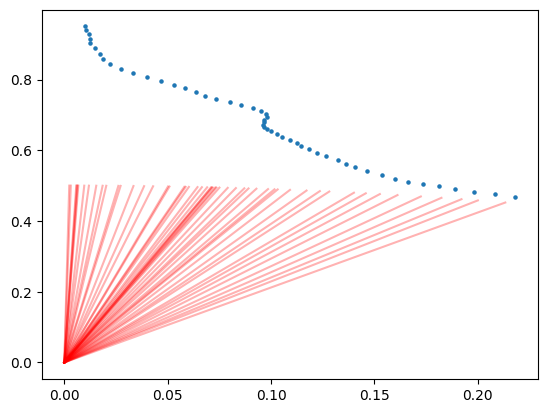

In [5]:
render(trace)


In [6]:
function particle_filter(num_particles::Int, zs::Vector{Float64}, num_samples::Int)
    
    # construct initial observations
    init_obs = Gen.choicemap((:z0, zs[1]))
    state = Gen.initialize_particle_filter(model, (0,), init_obs, num_particles)
    
    # steps
    for t=1:length(zs)-1
        Gen.maybe_resample!(state, ess_threshold=num_particles/2)
        obs = Gen.choicemap(((:z, t), zs[t+1]))
        Gen.particle_filter_step!(state, (t,), (UnknownChange(),), obs)
    end
    
    # return a sample of unweighted traces from the weighted collection
    return Gen.sample_unweighted_traces(state, num_samples)
end;

In [10]:
@time pf_traces = particle_filter(500, zs, 200);


  3.793241 seconds (42.56 M allocations: 1.388 GiB, 20.31% gc time)


In [11]:
function overlay(renderer, traces; same_data=true, args...)
    renderer(traces[1], show_data=true, args...)
    for i=2:length(traces)
        renderer(traces[i], show_data=!same_data, args...)
    end
end;



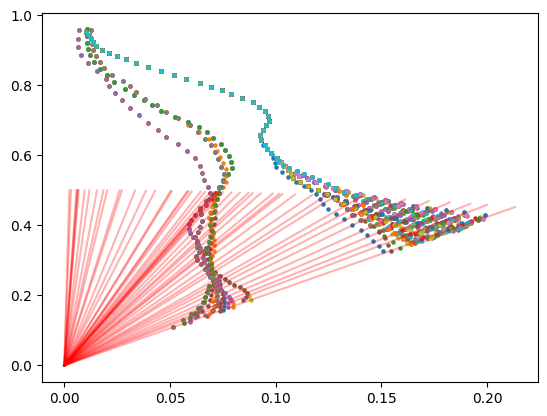


signal (15): Terminated: 15
in expression starting at /Users/aidancurtis/.julia/packages/IJulia/e8kqU/src/kernel.jl:53


In [12]:
overlay(render, pf_traces, same_data=true)
